In [1]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Conv1D, TimeDistributed, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import backend as K
import time
import numpy as np

In [3]:
# 損失函數
def l2_loss(y_true, y_pred):
    diff = y_true - y_pred
    loss = tf.reduce_mean(tf.square(diff))
    return loss

In [4]:
model = load_model('saved_model_stage1_CNN_new\CNN_epoch_200_stage1.h5', custom_objects={'l2_loss':l2_loss})

In [6]:
model = Model(inputs=model.input, outputs=model.get_layer('reshape').output)

In [7]:
# 加上全連接層
x = model.output

predictions = Dense(11, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

In [8]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 2)]       0         
                                                                 
 online_cnn_fw/depthwise_con  (None, 15, 15, 2)        18        
 v2d_9/depthwise1 (Depthwise                                     
 Conv2D)                                                         
                                                                 
 online_cnn_fw/conv2d_9/Conv  (None, 15, 15, 32)       64        
 2D (Conv2D)                                                     
                                                                 
 online_cnn_fw/depthwise_con  (None, 7, 7, 32)         288       
 v2d_10/depthwise1 (Depthwis                                     
 eConv2D)                                                        
                                                           

In [9]:
# 載入資料集
def load_gesture_data(directory):
    gesture_data = []
    labels = []
    
    categories = []
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            categories.append(category)
    
    category_files = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        files = []
        for file in os.listdir(category_path):
            if file.endswith('.npy'):
                files.append(file)
        category_files[category] = files
    
    max_files = 0
    for files in category_files.values():
        if len(files) > max_files:
            max_files = len(files)
    
    for i in range(max_files):
        for category in categories:
            files = category_files[category]
            
            if i < len(files):
                file_name = files[i]
                file_path = os.path.join(category, file_name)
                file_path_full = os.path.join(directory, file_path)
                print(f"Loading {file_path_full}")
                data = np.load(file_path_full)
                gesture_data.append(data)
                labels.append(category)  
    
    return np.array(gesture_data), labels


In [10]:
# Load gesture data
gesture_data_train, gesture_labels_train = load_gesture_data('traindata_bath/train')
gesture_data_test, gesture_labels_test = load_gesture_data('traindata_bath/test')
gesture_data_val, gesture_labels_val = load_gesture_data('traindata_bath/validation')

print("Original Gesture data train shape:", np.shape(gesture_data_train))
print("Original Gesture labels train shape:", np.shape(gesture_labels_train))

x_train_gesture = np.reshape(gesture_data_train, (-1, 2, 32, 32, 35))
x_test_gesture = np.reshape(gesture_data_test, (-1, 2, 32, 32, 35))
x_val_gesture = np.reshape(gesture_data_val, (-1, 2, 32, 32, 35))

x_train_gesture = np.transpose(x_train_gesture, [0, 4, 2, 3, 1]).reshape(-1, 32, 32, 2)
x_test_gesture = np.transpose(x_test_gesture, [0, 4, 2, 3, 1]).reshape(-1, 32, 32, 2)
x_val_gesture = np.transpose(x_val_gesture, [0, 4, 2, 3, 1]).reshape(-1, 32, 32, 2)

gesture_labels_train = np.repeat(gesture_labels_train, 35)
gesture_labels_test = np.repeat(gesture_labels_test, 35)
gesture_labels_val = np.repeat(gesture_labels_val, 35)

label_encoder = LabelEncoder()
gesture_labels_train_encoded = label_encoder.fit_transform(gesture_labels_train)
gesture_labels_test_encoded = label_encoder.transform(gesture_labels_test)
gesture_labels_val_encoded = label_encoder.transform(gesture_labels_val)

gesture_labels_train_one_hot = to_categorical(gesture_labels_train_encoded, num_classes=11)
gesture_labels_test_one_hot = to_categorical(gesture_labels_test_encoded, num_classes=11)
gesture_labels_val_one_hot = to_categorical(gesture_labels_val_encoded, num_classes=11)

gesture_labels_train_one_hot = np.reshape(gesture_labels_train_one_hot, (-1, 1, 11))
gesture_labels_test_one_hot = np.reshape(gesture_labels_test_one_hot, (-1, 1, 11))
gesture_labels_val_one_hot = np.reshape(gesture_labels_val_one_hot, (-1, 1, 11))

print("Reshaped Gesture data train shape:", x_train_gesture.shape)
print("Reshaped Gesture labels train shape:", gesture_labels_train_one_hot.shape)

Loading traindata_bath/train\bath_BG_Static\ST_falldown_0.npy
Loading traindata_bath/train\bath_falldown\bath_falldown_segment_0.npy
Loading traindata_bath/train\bath_nono\bath_nono_segment_10000.npy
Loading traindata_bath/train\bath_patpat\bath_patpat_segment_100.npy
Loading traindata_bath/train\bath_slowUp\bath_slowUp_segment_10046.npy
Loading traindata_bath/train\bath_swipeDown\bath_swipeDown_segment_10082.npy
Loading traindata_bath/train\bath_swipeLeft\bath_swipeLeft_segment_10122.npy
Loading traindata_bath/train\bath_swipeRight\bath_swipeRight_segment_10159.npy
Loading traindata_bath/train\bath_swipeUp\bath_swipeUp_segment_10197.npy
Loading traindata_bath/train\bath_BG_Static\ST_falldown_1.npy
Loading traindata_bath/train\bath_falldown\bath_falldown_segment_1.npy
Loading traindata_bath/train\bath_nono\bath_nono_segment_10001.npy
Loading traindata_bath/train\bath_patpat\bath_patpat_segment_1000.npy
Loading traindata_bath/train\bath_slowUp\bath_slowUp_segment_10047.npy
Loading train

In [11]:
# 隨機背景採樣
import numpy as np

def load_and_select_data(num_selections, num_bg_classes=2, num_gesture_classes=9, validation_split=0.1, TimeSp=35):
    # Load the data
    path1 = "traindata_bath/bath_background\data_Background_0001_2024_08_22_19_45_18.h5.npy"
    data1 = np.load(path1)
    labels1 = np.full(data1.shape[-1], fill_value=9)  # Background 1

    path2 = "traindata_bath/bath_falldown_BG\data_Background_0001_2024_08_23_01_40_06.h5.npy"
    data2 = np.load(path2)
    labels2 = np.full(data2.shape[-1], fill_value=10)  # Background 2

    def slice35(data, labels, TimeSp):
        segments = []
        segment_labels = []
        for j in range(0, data.shape[-1] - TimeSp + 1, TimeSp):
            segment = data[..., j:j + TimeSp]
            segments.append(segment)
            segment_labels.append(labels[j:j + TimeSp])
        return np.array(segments), np.array(segment_labels)

    data1_segments, labels1_segments = slice35(data1, labels1, TimeSp)
    data2_segments, labels2_segments = slice35(data2, labels2, TimeSp)

    data1_segments = np.transpose(data1_segments, [0, 4, 2, 3, 1]).reshape(-1, 32, 32, 2)
    data2_segments = np.transpose(data2_segments, [0, 4, 2, 3, 1]).reshape(-1, 32, 32, 2)

    all_segments = np.concatenate([data1_segments, data2_segments], axis=0)
    all_labels = np.concatenate([labels1_segments, labels2_segments], axis=0)

    all_labels = np.ravel(all_labels)

    class_proportions = {
        9: 0.5,
        10: 0.5,
    }

    num_classes = num_bg_classes + num_gesture_classes
    selected_segments = []
    selected_labels = []

    for class_id, proportion in class_proportions.items():
        class_indices = np.where(all_labels == class_id)[0]
        num_class_samples = int(proportion * num_selections)
        selected_class_indices = np.random.choice(class_indices, size=num_class_samples)
        selected_segments.extend(all_segments[selected_class_indices])
        selected_labels.extend(all_labels[selected_class_indices])

    selected_segments = np.array(selected_segments)
    selected_labels = np.array(selected_labels)

    num_val_samples = int(validation_split * selected_segments.shape[0])
    val_indices = np.random.choice(len(selected_segments), size=num_val_samples)

    train_indices = np.setdiff1d(np.arange(len(selected_segments)), val_indices)

    val_segments = selected_segments[val_indices]
    val_labels = selected_labels[val_indices]

    train_segments = selected_segments[train_indices]
    train_labels = selected_labels[train_indices]

    one_hot_train_labels = np.zeros((len(train_labels), num_classes), dtype=np.float32)
    one_hot_val_labels = np.zeros((len(val_labels), num_classes), dtype=np.float32)

    one_hot_train_labels[np.arange(len(train_labels)), train_labels] = 1
    one_hot_val_labels[np.arange(len(val_labels)), val_labels] = 1

    one_hot_train_labels = np.reshape(one_hot_train_labels, (-1, 1, num_classes))
    one_hot_val_labels = np.reshape(one_hot_val_labels, (-1, 1, num_classes))

    return train_segments, one_hot_train_labels, val_segments, one_hot_val_labels

In [43]:
# 查看背景資料比例
import numpy as np

selected_train_data, one_hot_train_labels, selected_val_data, one_hot_val_labels = load_and_select_data(num_selections=3000)

class_proportions = np.sum(one_hot_train_labels, axis=0).flatten() / len(one_hot_train_labels)

for i in range(len(class_proportions)):
    class_type = "Background" if i < 3 else "Gesture"
    print(f"Class {i} ({class_type}): {class_proportions[i]:.2%}")


Class 0 (Background): 0.00%
Class 1 (Background): 0.00%
Class 2 (Background): 0.00%
Class 3 (Gesture): 0.00%
Class 4 (Gesture): 0.00%
Class 5 (Gesture): 0.00%
Class 6 (Gesture): 0.00%
Class 7 (Gesture): 0.00%
Class 8 (Gesture): 0.00%
Class 9 (Gesture): 32.98%
Class 10 (Gesture): 33.47%
Class 11 (Gesture): 33.55%


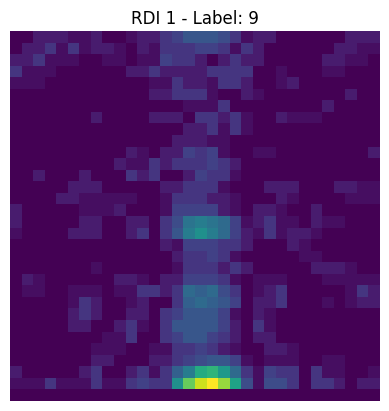

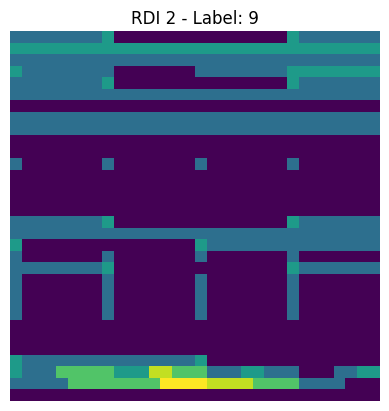

In [44]:
# 實際print觀察
import numpy as np
import matplotlib.pyplot as plt

def normalize_data(data):
    return 255 * (data - np.min(data)) / np.ptp(data)

def plot_data_segment(segment_data, label):
    tfdataN = normalize_data(segment_data)

    for i in range(tfdataN.shape[-1]):
        plt.figure()
        plt.imshow(tfdataN[:, :, i])
        plt.title(f'RDI {i + 1} - Label: {label}')
        plt.axis('off')
        plt.show()

segment_index = 100
plot_data_segment(selected_train_data[segment_index], np.argmax(one_hot_train_labels[segment_index]))


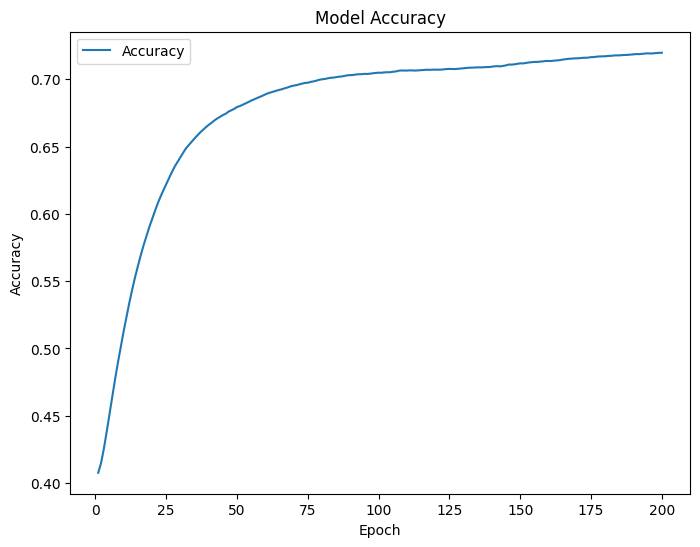

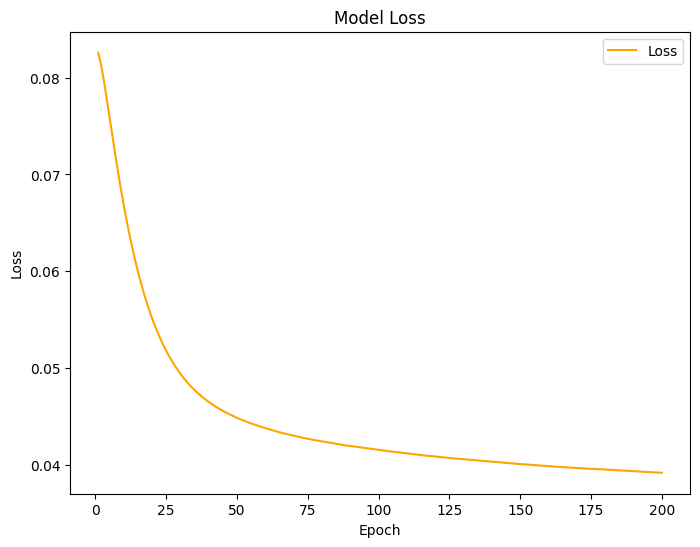

In [15]:
# 根據log畫val acc 和 loss
import re
import matplotlib.pyplot as plt

log_data = """
EP: 1
[============================================================] 99.9% ...61.77556610107422 sec Loss = 0.07876971306072342
ACC = 0.24801422643746296
EP: 2
[============================================================] 99.9% ...126.12714076042175 sec Loss = 0.07489411611523893
ACC = 0.2871501020878614
EP: 3
[============================================================] 99.9% ...184.6972177028656 sec Loss = 0.07314291132820977
ACC = 0.3111242837383916
EP: 4
[============================================================] 99.9% ...248.73712754249573 sec Loss = 0.07160993739962578
ACC = 0.3249687150102088
EP: 5
[============================================================] 99.9% ...306.98822569847107 sec Loss = 0.07026945947565966
ACC = 0.3381676875452809
EP: 6
[============================================================] 99.9% ...361.1445245742798 sec Loss = 0.06914253341447976
ACC = 0.3455180135678061
EP: 7
[============================================================] 99.9% ...416.82227778434753 sec Loss = 0.06806606853173838
ACC = 0.3603372192583811
EP: 8
[============================================================] 99.9% ...470.9464807510376 sec Loss = 0.06722973199147317
ACC = 0.37668444971349535
"""

pattern = re.compile(
    r"EP: (\d+).*?Loss = ([\d.]+).*?ACC = ([\d.]+)",
    re.DOTALL
)

epochs = []
losses = []
accuracies = []

for match in pattern.finditer(log_data):
    epochs.append(int(match.group(1)))
    losses.append(float(match.group(2)))
    accuracies.append(float(match.group(3)))

else:
    def exponential_smoothing(data, alpha=0.1):   
        smoothed_data = [data[0]]
        for point in data[1:]:
            smoothed_data.append(alpha * point + (1 - alpha) * smoothed_data[-1])
        return smoothed_data

    alpha = 0.1 
    smoothed_accuracies = exponential_smoothing(accuracies, alpha)
    smoothed_losses = exponential_smoothing(losses, alpha)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, smoothed_accuracies, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, smoothed_losses, label='Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.show()


In [12]:
def AGIprogressBar(count, total,start):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)
    duration=time.time()-start
    print('\r[%s] %s%s ...%s sec' % (bar, percents, '%', duration),end=' ')

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss=l2_loss, metrics=['accuracy'])

In [14]:
# 跑
Batch = 840
epochs = 200
rec = []
losses = []
st = time.time()

for ep in range(epochs):
    num_train_selections = 153330
    x_train, y_train, x_val, y_val = load_and_select_data(num_selections=num_train_selections)

    x_train_combined = np.concatenate((x_train_gesture, x_train), axis=0)
    y_train_combined = np.concatenate((gesture_labels_train_one_hot, y_train), axis=0)

    x_val_combined = np.concatenate((x_val_gesture, x_val), axis=0)
    y_val_combined = np.concatenate((gesture_labels_val_one_hot, y_val), axis=0)

    print(f'EP: {ep + 1}')
    
    indices = np.arange(len(x_train_combined))
    np.random.shuffle(indices)
    x_train_combined = x_train_combined[indices]
    y_train_combined = y_train_combined[indices]
    epoch_loss = 0
    
    for i in range(len(x_train_combined) // Batch):
        AGIprogressBar(i, len(x_train_combined) // Batch, st)

        x_batch = x_train_combined[i*Batch:(i+1)*Batch]
        y_batch = y_train_combined[i*Batch:(i+1)*Batch]

        resultSt = model.train_on_batch(x_batch, y_batch)
        batch_loss = resultSt[0]
        epoch_loss += batch_loss
    
    epoch_loss /= (len(x_train_combined) // Batch)
    losses.append(epoch_loss)
    print(f'Loss = {epoch_loss}')

    pre = model.predict(x_val_combined, verbose=0)
    acc = np.sum(np.argmax(pre, axis=2) == np.argmax(np.array(y_val_combined), axis=2)) / len(y_val_combined)
    rec.append(acc)
    print(f'ACC = {acc}')

    if (ep + 1) % 10 == 0:
        model.save(f'saved_model_stage2_CNN_bath_new/CNN_epoch_{ep + 1}_stage1.h5')
        print(f'Model saved at epoch {ep + 1}')


EP: 1
[============================================================] 99.9% ...57.65728497505188 sec Loss = 0.08256823350401486
ACC = 0.4076538475997143
EP: 2
[============================================================] 99.9% ...123.10319948196411 sec Loss = 0.07030672804008123
ACC = 0.47845319098279515
EP: 3
[============================================================] 99.9% ...185.81650495529175 sec Loss = 0.06485593516647425
ACC = 0.5230129193138102
EP: 4
[============================================================] 99.9% ...243.18308687210083 sec Loss = 0.06114381901384179
ACC = 0.5513577183815145
EP: 5
[============================================================] 99.9% ...300.6995441913605 sec Loss = 0.0585970736163504
ACC = 0.5702417202360813
EP: 6
[============================================================] 99.9% ...358.6494388580322 sec  Loss = 0.05658165955173424
ACC = 0.5881733769407165
EP: 7
[============================================================] 99.9% ...417.00

In [ ]:
# 合併手勢、背景測試資料
x_test_combined = np.concatenate((x_test_gesture, x_val), axis=0)
y_test_combined = np.concatenate((gesture_labels_test_one_hot, y_val), axis=0)

In [ ]:
# 洗牌
indices = np.random.permutation(len(x_test_combined))

x_test_combined_shuffled = x_test_combined[indices]
y_test_combined_shuffled = y_test_combined[indices]

2478/2478 [==============================] - 7s 3ms/step
Confusion Matrix:
 [[14976   446   113   183   277   169   336   150   363]
 [  982  6598     0     0     0     0     0    16    34]
 [   36     0  4477  1150   930   149   746   250   242]
 [    0     0   485  4398  1251   118   909   350   154]
 [   86     0   241   604  4777   291   865   221   405]
 [   17     0    24   107   116  5088   603   267  1268]
 [   26     4    43   541   613   429  4882   659   713]
 [    0     0   204   159   184   725   942  4797  1039]
 [    9     0    40   130    89  1089   916   373  5404]]


<Figure size 800x600 with 0 Axes>

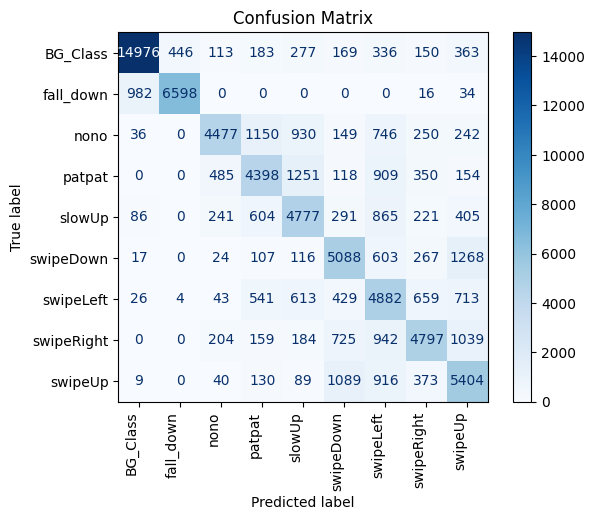

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert one-hot encoded labels to class indices for the true labels
y_true = np.argmax(y_test_combined, axis=2)

# Predicting probabilities with the model
y_pred_prob = model.predict(x_test_combined)

# Convert predicted probabilities to class indices
y_pred = np.argmax(y_pred_prob, axis=2)

# Merge the classes into a single class (assuming these classes are 0, 9, 10 in original labels)
merge_map = {0: 0, 9: 0, 10: 0, 11: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}
y_true_merged = np.vectorize(merge_map.get)(y_true)
y_pred_merged = np.vectorize(merge_map.get)(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_true_merged, y_pred_merged)

# Print the confusion matrix
print("Confusion Matrix:\n", cm)

# Gesture class labels (merged 'bath_BG_Static', 'bath_BG', 'bath_falldown_BG' into 'BG_Class')
classes = ['BG_Class', 'fall_down', 'nono', 'patpat', 'slowUp', 'swipeDown', 'swipeLeft', 'swipeRight', 'swipeUp']

# Visualize the confusion matrix using Matplotlib
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90, ha='right')
plt.show()


2478/2478 [==============================] - 6s 3ms/step
Confusion Matrix:
 [[   0  105  105  175  245  140  315  140  315   35  105]
 [   0 6598    0    0    0    0    0   16   34   64  918]
 [   0    0 4477 1150  930  149  746  250  242   36    0]
 [   0    0  485 4398 1251  118  909  350  154    0    0]
 [   0    0  241  604 4777  291  865  221  405   86    0]
 [   0    0   24  107  116 5088  603  267 1268   17    0]
 [   0    4   43  541  613  429 4882  659  713   26    0]
 [   0    0  204  159  184  725  942 4797 1039    0    0]
 [   0    0   40  130   89 1089  916  373 5404    9    0]
 [   0   80    7    2   22   22   21   10   48 7410   30]
 [   0  261    1    6   10    7    0    0    0   32 7364]]


<Figure size 800x600 with 0 Axes>

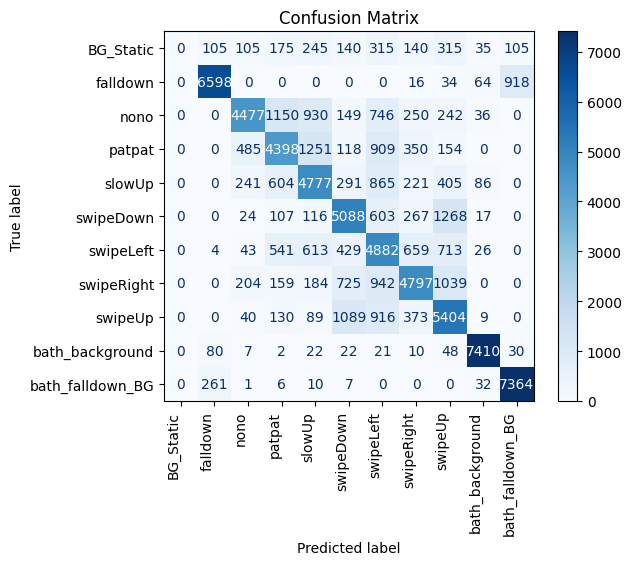

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming gesture_labels_test_one_hot is the one-hot encoded labels
# and x_test_gesture is your test dataset
# Assuming model is your trained model

# Convert one-hot encoded labels to class indices for the true labels
y_true = np.argmax(y_test_combined, axis=2)

# Predicting probabilities with the model
y_pred_prob = model.predict(x_test_combined)

# Convert predicted probabilities to class indices
y_pred = np.argmax(y_pred_prob, axis=2)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:\n", cm)

# Gesture class labels
classes = ['BG_Static', 'falldown', 'nono', 'patpat', 'slowUp', 'swipeDown', 'swipeLeft', 'swipeRight', 'swipeUp', 'bath_background', 'bath_falldown_BG']

# Visualize the confusion matrix using Matplotlib
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90, ha='right')
plt.show()


In [23]:
# 神經元分析
# hook其中幾層 CNN
hook=[]
id=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for i in range(len(id)):
  hook.append(model.layers[id[i]].output)
ModelExtract = Model(inputs=model.input, outputs=hook)


In [7]:
# 以下程式碼用來Predict CNN 以取得LSTM訓練集
model = load_model('saved_model_stage1_CNN_1\CNN_epoch_760_stage1.h5', custom_objects={'l2_loss':l2_loss})

In [35]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 2)]       0         
                                                                 
 online_cnn_fw/depthwise_con  (None, 15, 15, 2)        18        
 v2d_9/depthwise1 (Depthwise                                     
 Conv2D)                                                         
                                                                 
 online_cnn_fw/conv2d_9/Conv  (None, 15, 15, 32)       64        
 2D (Conv2D)                                                     
                                                                 
 online_cnn_fw/depthwise_con  (None, 7, 7, 32)         288       
 v2d_10/depthwise1 (Depthwis                                     
 eConv2D)                                                        
                                                           

In [36]:
# hook BN Layer
hook=[]
id=[10]
for i in range(len(id)):
  hook.append(model.layers[id[i]].output)
ModelExtract = Model(inputs=model.input, outputs=hook)


In [37]:
ModelExtract.output

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'batch_normalization')>

In [41]:
predictions = ModelExtract.predict(x_train_gesture)
labels = gesture_labels_train_one_hot

15113/15768 [===========================>..] - ETA: 1s

In [40]:
# 根據需求保存預測結果
np.save('Stage_Bath_LSTM/predictions_train.npy', predictions)
np.save('Stage_Bath_LSTM/predictions_labels_train', labels)

In [12]:
path1 = "dataset\\BackGround_MV_809\\data_Background_0001_2024_08_22_12_08_35.h5.npy"
data1 = np.load(path1)

path2 = "dataset\\BackGround_MV_809_pat\\data_Background_0001_2024_08_22_12_17_23.h5.npy"
data2 = np.load(path2)

path3 = "dataset\\BackGround_falldown\\data_Background_0001_2024_08_22_15_50_59.h5.npy"
data3 = np.load(path3)

In [52]:
data1 = np.transpose(data1, [3, 1, 2, 0])

In [53]:
predictions = ModelExtract.predict(data1)

67/67 [==============================] - 0s 2ms/step


In [21]:
np.save('LSTM\LSTM_STAGE1/BackGround_falldown.npy', predictions)

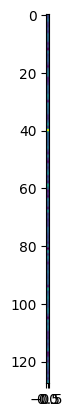

In [49]:
tfdata = predictions
tfdataN=255*(tfdata-np.min(tfdata)/np.max(tfdata))
plt.imshow(tfdataN[0].reshape(-1, 1))

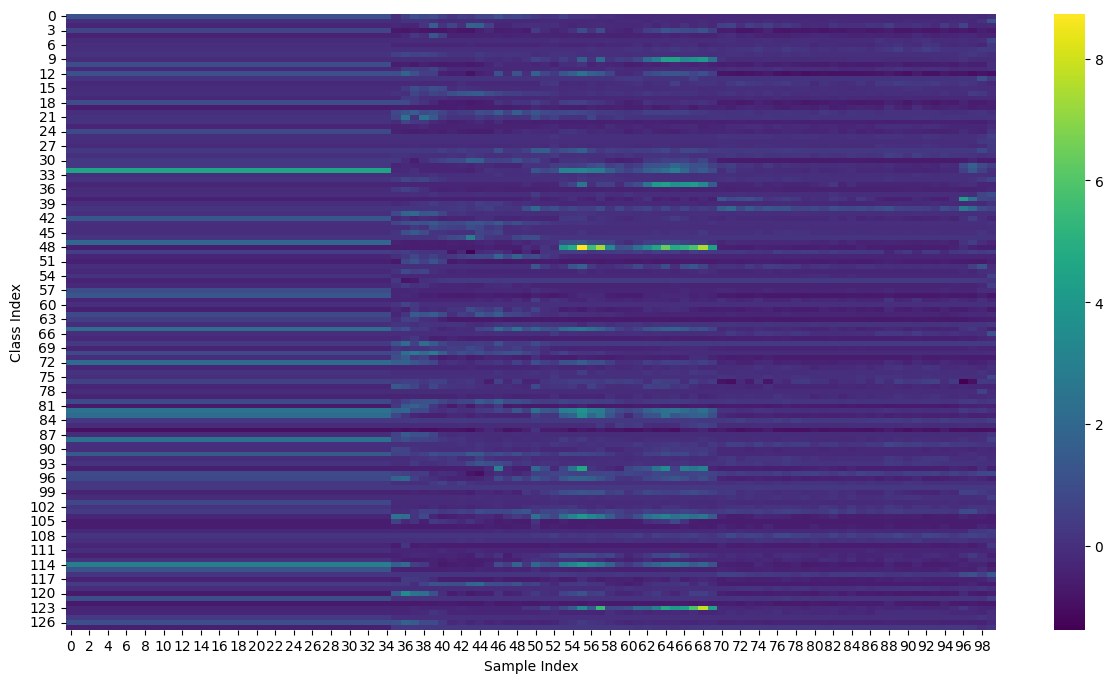

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.heatmap(predictions[:100].T, cmap="viridis", cbar=True)
plt.xlabel('Sample Index')
plt.ylabel('Class Index')
plt.show()


In [79]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 2)]       0         
                                                                 
 online_cnn_fw/depthwise_con  (None, 15, 15, 2)        18        
 v2d_9/depthwise1 (Depthwise                                     
 Conv2D)                                                         
                                                                 
 online_cnn_fw/conv2d_9/Conv  (None, 15, 15, 32)       64        
 2D (Conv2D)                                                     
                                                                 
 online_cnn_fw/depthwise_con  (None, 7, 7, 32)         288       
 v2d_10/depthwise1 (Depthwis                                     
 eConv2D)                                                        
                                                             

In [24]:
# 神經元分析
# hook其中幾層 CNN
hook=[]
id=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for i in range(len(id)):
  hook.append(model.layers[id[i]].output)
ModelExtract = Model(inputs=model.input, outputs=hook)


In [25]:
ModelExtract.output

[<KerasTensor: shape=(None, 32, 32, 2) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 15, 15, 2) dtype=float32 (created by layer 'online_cnn_fw/depthwise_conv2d_9/depthwise1')>,
 <KerasTensor: shape=(None, 15, 15, 32) dtype=float32 (created by layer 'online_cnn_fw/conv2d_9/Conv2D')>,
 <KerasTensor: shape=(None, 7, 7, 32) dtype=float32 (created by layer 'online_cnn_fw/depthwise_conv2d_10/depthwise1')>,
 <KerasTensor: shape=(None, 7, 7, 64) dtype=float32 (created by layer 'online_cnn_fw/conv2d_10/Conv2D')>,
 <KerasTensor: shape=(None, 7, 7, 64) dtype=float32 (created by layer 'dropout')>,
 <KerasTensor: shape=(None, 3, 3, 64) dtype=float32 (created by layer 'online_cnn_fw/depthwise_conv2d_11/depthwise1')>,
 <KerasTensor: shape=(None, 3, 3, 128) dtype=float32 (created by layer 'online_cnn_fw/conv2d_11/Conv2D1')>,
 <KerasTensor: shape=(None, 3, 3, 128) dtype=float32 (created by layer 'dropout_1')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer '

In [26]:
# 統一使用50000筆資料觀察模型各層的資料分布
predictions = ModelExtract.predict(x_test_combined_shuffled[:50000])
labels = np.argmax(y_test_combined_shuffled[:50000], axis=2)

1563/1563 [==============================] - 5s 3ms/step


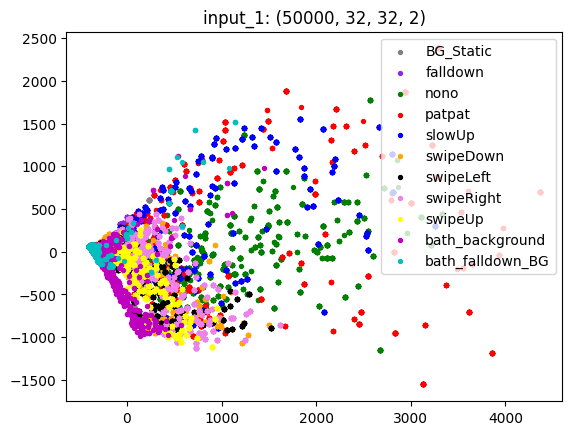

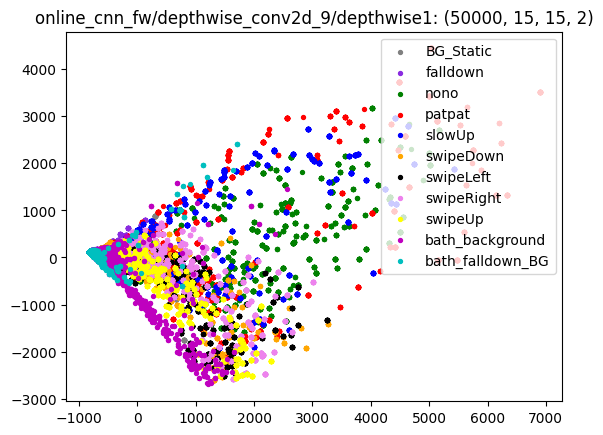

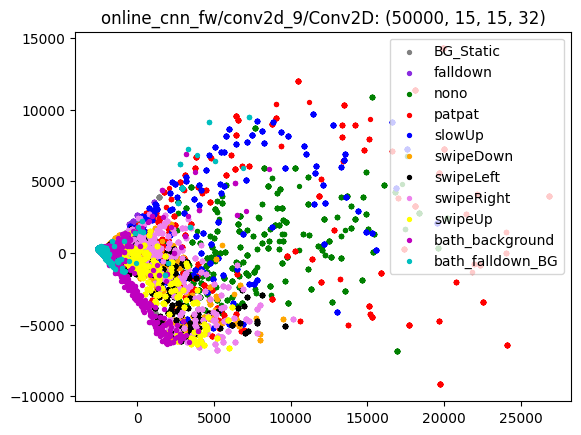

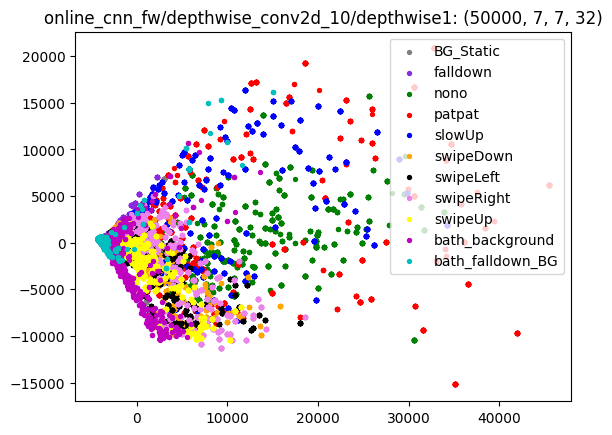

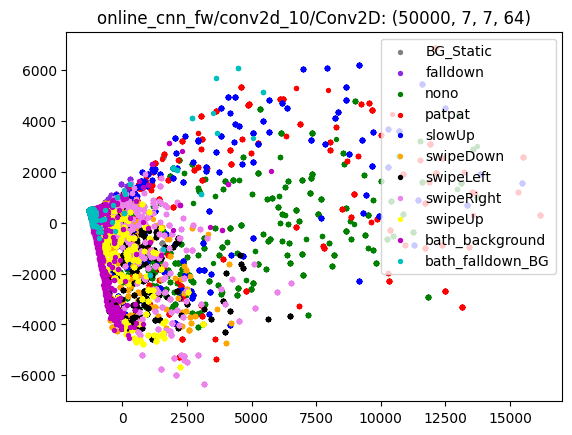

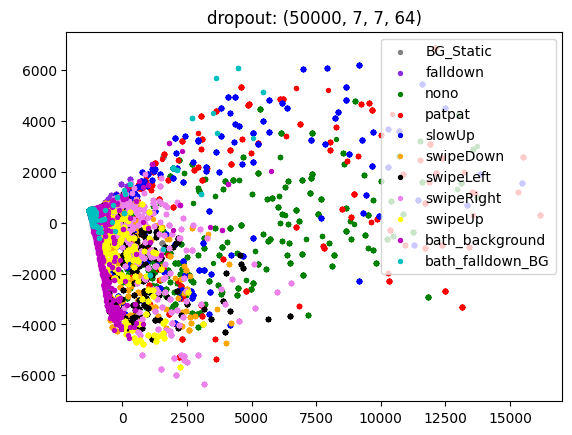

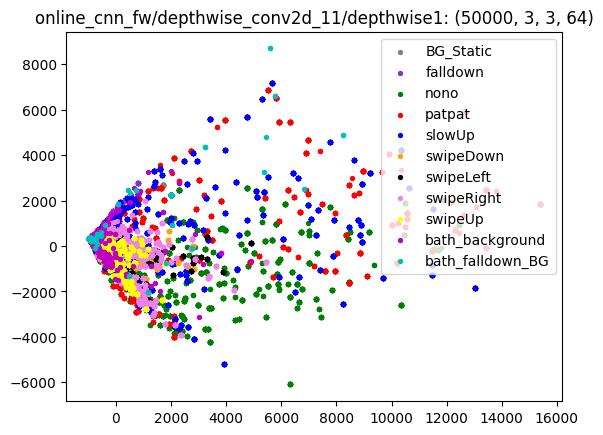

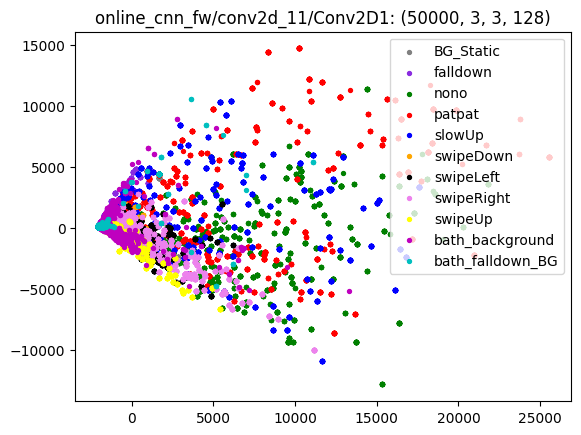

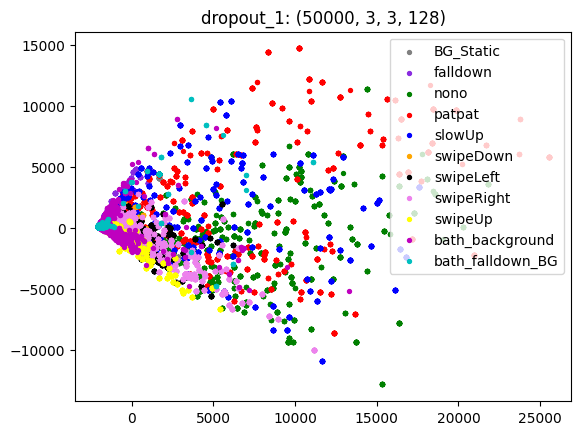

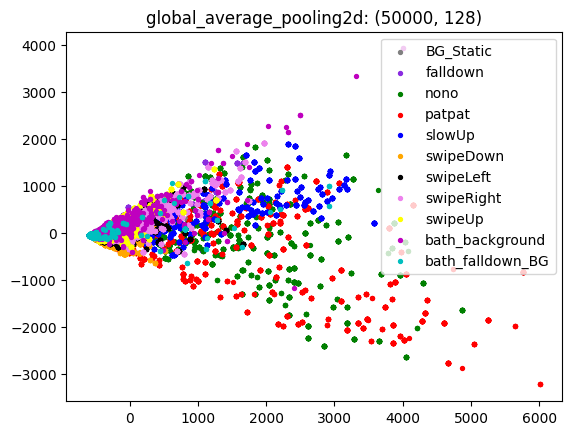

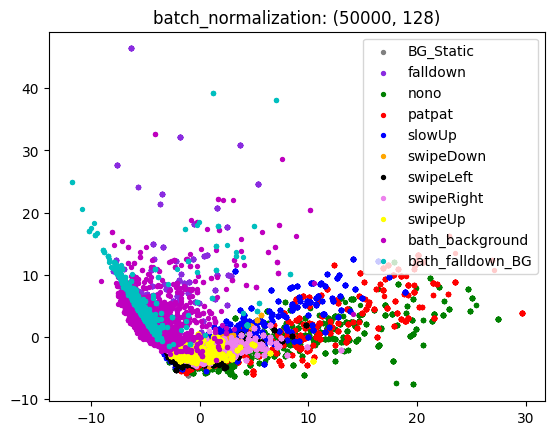

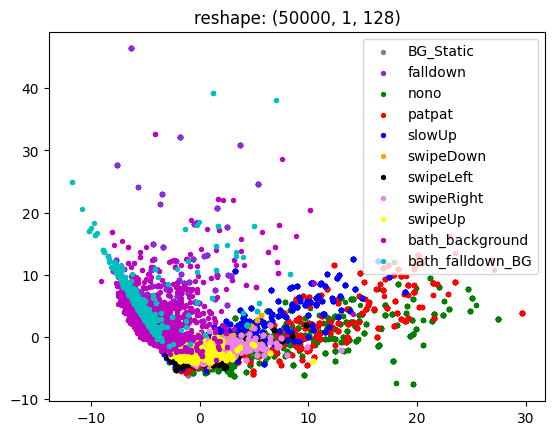

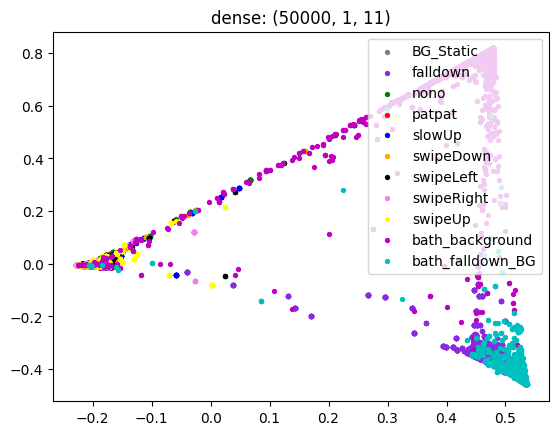

In [30]:
# PCA 
from sklearn import decomposition
PCA=[]

classes = ['BG_Static', 'falldown', 'nono', 'patpat', 'slowUp', 'swipeDown', 'swipeLeft', 'swipeRight', 'swipeUp', 'bath_background', 'bath_falldown_BG']

label_to_color = {
    'patpat': [1, 0, 0, 1], # Red
    'nono': [0, 0.5, 0, 1], # Green
    'slowUp': [0, 0, 1, 1], # Blue
    'swipeDown': [1, 0.65, 0, 1], # Orange
    'swipeUp': [1, 1, 0, 1], # Yellow
    'swipeLeft': [0, 0, 0, 1], # Black
    'swipeRight': [0.93, 0.51, 0.93, 1], # Violet
    'falldown': [0.54, 0.17, 0.88, 1], # Purple
    'background_moving': [0, 1, 1, 1], # Cyan
    'BG_Static': [0.5, 0.5, 0.5, 1], # Gray
    'bath_background': [0.75, 0, 0.75, 1], # Magenta
    'bath_falldown_BG': [0, 0.75, 0.75, 1] # Teal
}

for i in range(len(predictions)):
    input=np.reshape(predictions[i],[len(predictions[i]),-1])
    pca=decomposition.PCA(n_components=2)
    pca.fit(input)
    PCA.append(pca)
    Dim2=PCA[-1].transform(input)
    plt.figure()
    plt.title(model.layers[id[i]].name+': '+f'{predictions[i].shape}')
    for cl in range(11):
        chos=Dim2[np.argwhere(labels==cl).reshape([-1])]
        color = label_to_color[classes[cl]]
        plt.scatter(chos[:, 0], chos[:, 1], label=classes[cl], marker='o', s=8, color=color)
    plt.legend(loc=1)